In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams.update({'font.size': 22})
sns.set_style('white')

In [45]:
declarations_df = pd.read_csv('data/declarations.csv')
declarations_df.head()

,person_id,person_name,year,office_id,office_name,income,savings,real_estate_amount,real_estate_squares
0,8,Зюганов Геннадий Андреевич,1998,14,Государственная Дума,124154.00,0.00,1,150.0
1,8,Зюганов Геннадий Андреевич,1999,449,Президент Российской Федерации,506247.00,0.00,3,252.7
2,8,Зюганов Геннадий Андреевич,2006,14,Государственная Дума,1257784.00,141740.91,1,167.4
3,8,Зюганов Геннадий Андреевич,2006,449,Президент Российской Федерации,3590668.48,400490.32,2,281.3
4,8,Зюганов Геннадий Андреевич,2009,14,Государственная Дума,2177821.52,0.00,3,448.7


In [46]:
declarations_df.office_name = declarations_df.office_name.apply(lambda x: x.replace(' ', '\n')) # For plotting

In [47]:
office_names = declarations_df[['office_id', 'office_name']].drop_duplicates().reset_index(drop=True)
office_names.index = office_names.office_id
office_names = office_names.drop(['office_id'], axis=1)
office_names

,office_name
office_id,
14,Государственная\nДума
449,Президент\nРоссийской\nФедерации
118,Государственное\n\nсобрание\n–\nКурултай\nРесп...
267,Законодательное\nсобрание\nАлтайского\nкрая
211,Губернатор\nИркутской\nобласти
1575,Новосибирск\n-\nгородской\nокруг
258,Мэр\nгорода\nМосквы
5,Совет\nФедерации
15,Счетная\nпалата


# Plan
## Meta
* Total declarations
* Declarations by year
* Declarations by office

## Basic info 
* Total people
* Total offices
* People distribution by years
* People distribution by office
* People distribution by years by office

## Declared assets
* Income, distributions
    * By year
* Richest people by year
    * Top 10 richest people in each year
* Median incomes by office
* Income vs years worked


# Meta

In [48]:
print(declarations_df.shape)

(90864, 9)


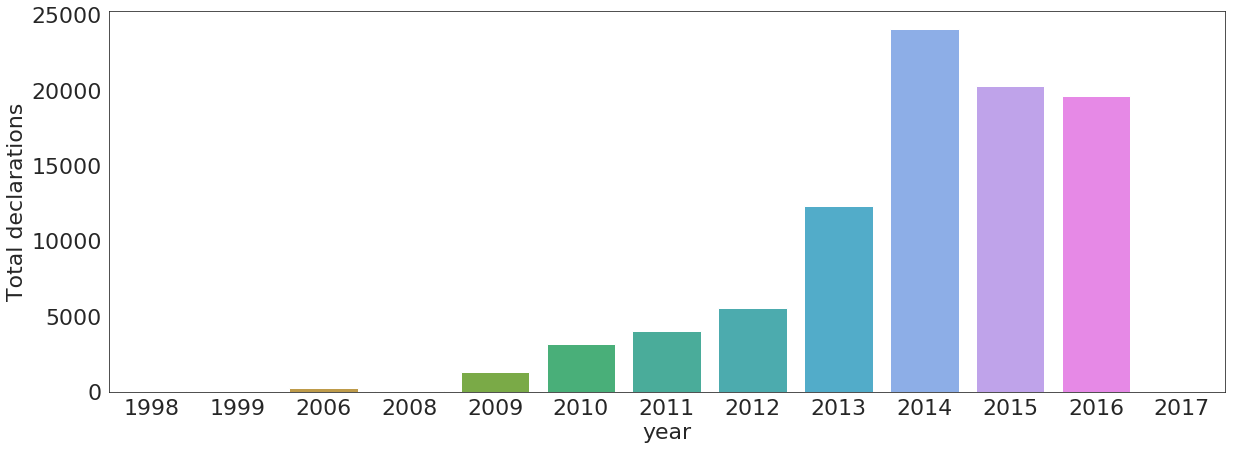

In [49]:
dec_count = declarations_df.groupby(['year'])['person_id'].count()
plt.figure(figsize=(20, 7))
sns.barplot(dec_count.index, dec_count)
plt.ylabel('Total declarations')
plt.show()

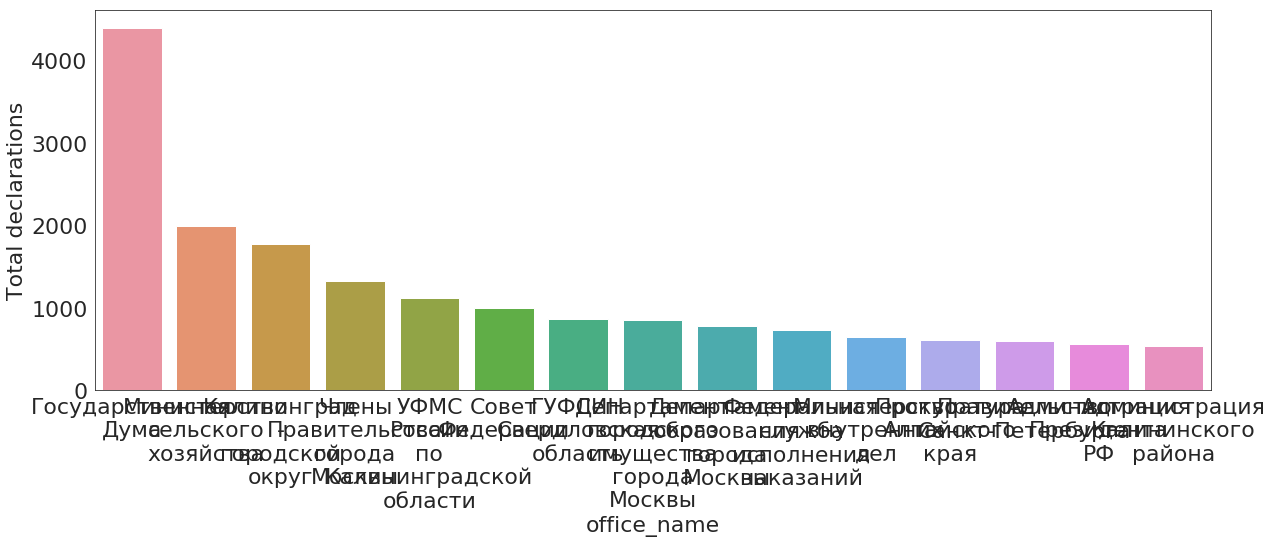

In [50]:
dec_count = declarations_df.groupby(['office_name'])['person_id'].count().sort_values(ascending=False).head(15)
plt.figure(figsize=(20, 7))
sns.barplot(dec_count.index, dec_count)
plt.ylabel('Total declarations')
plt.show()

It's only reasonable to analyze declarations from 2009 to 2016.
There is not enough data for other years.

In [51]:
declarations_df = declarations_df[(declarations_df.year >= 2009) & (declarations_df.year <= 2016)]

# People distribution, offices

In [52]:
print('Unique persons', declarations_df.person_id.unique().shape[0])
print('Unique offices', declarations_df.office_id.unique().shape[0])

Unique persons 51855
Unique offices 2104


Top 20 offices by unique people
The history saving thread hit an unexpected error (OperationalError('database or disk is full',)).History will not be written to the database.


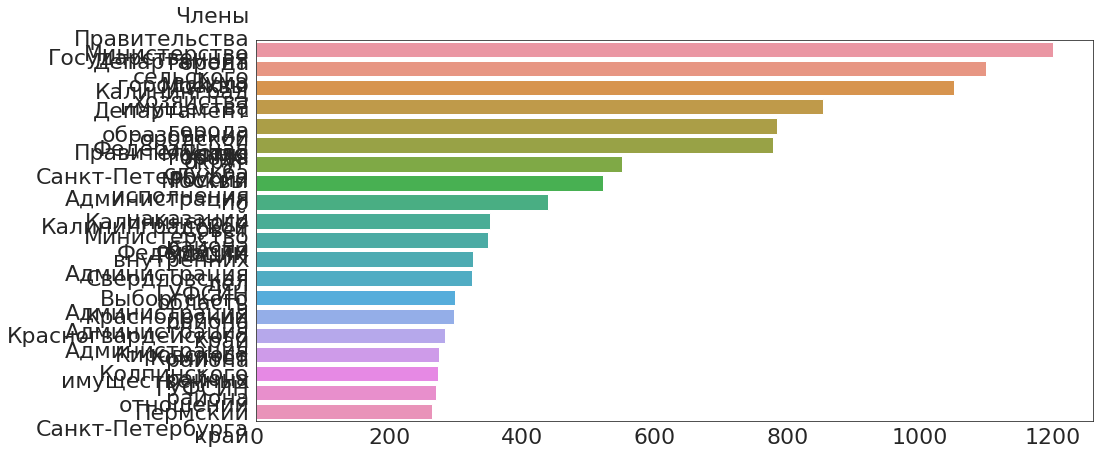

In [54]:
print('Top 20 offices by unique people')
unique_per_office = declarations_df.groupby(['office_id'])['person_id'].nunique().sort_values(ascending=False)

to_plot = unique_per_office.head(20)
plt.figure(figsize=(15, 7))
sns.barplot(y=office_names.loc[to_plot.index].values.flatten(), x=to_plot.values)
plt.show()

People per year


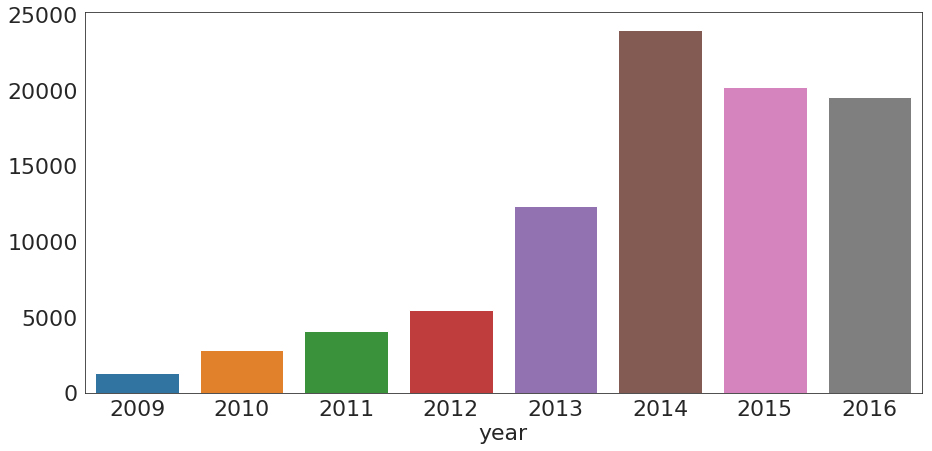

In [55]:
print('People per year')
unique_per_year = declarations_df.groupby(['year'])['person_id'].nunique().sort_values(ascending=False)
plt.figure(figsize=(15, 7))
sns.barplot(x=unique_per_year.index, y=unique_per_year.values)
plt.show()

Top 5 offices, people distribution by years


<Figure size 1080x2160 with 0 Axes>

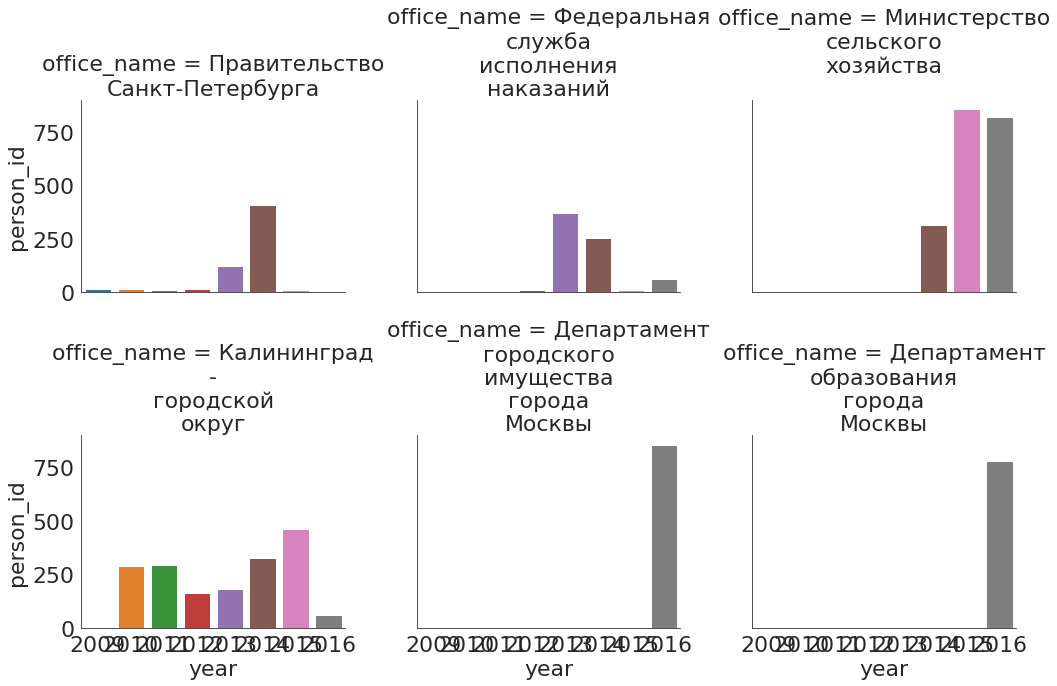

In [56]:
unique_per_office_per_year = declarations_df.groupby(['office_id', 'year'])['person_id'].nunique()

top_offices = unique_per_office.head(21).tail(19).head(6).index
to_plot = unique_per_office_per_year.loc[top_offices].reset_index()
to_plot = to_plot.merge(office_names.reset_index())
print('Top 5 offices, people distribution by years')
plt.figure(figsize=(15, 30))
sns.catplot(x='year', y='person_id', col='office_name', data=to_plot, kind='bar', col_wrap=3)
plt.show()

# Declared assets

In [57]:
income_sum = declarations_df.groupby(['person_id'])['income'].sum()
print(income_sum.shape)
income_sum.head()

(51855,)


person_id
8     4.005369e+07
9     1.427950e+08
10    3.131614e+07
11    1.134432e+07
12    6.979880e+07
Name: income, dtype: float64

In [16]:
income_sum = income_sum.sort_values(ascending=False)

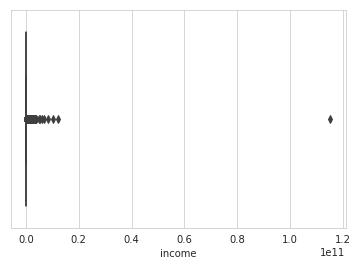

In [17]:
plt.figure()
sns.boxplot(income_sum)
plt.show()

### Income
* Total income per year
* Median income per year
* Median income per office
* Top offices by median income, per year

In [18]:
yearly_assets_sum = declarations_df.groupby(['year']).sum()
yearly_assets_sum.head()

,person_id,office_id,income,savings,real_estate_amount,real_estate_squares
year,,,,,,
2009,14176929,677522,1.226230e+10,3.582251e+06,7318,8.450908e+07
2010,24804715,2984690,1.476827e+11,2.981773e+10,15716,2.493375e+09
2011,37499642,4876663,3.864187e+10,5.337481e+06,21554,1.672665e+09
2012,49387222,6544753,3.943575e+10,1.117084e+08,29881,9.321092e+08
2013,223025368,23237238,5.753489e+10,3.647800e+04,64853,1.422688e+09


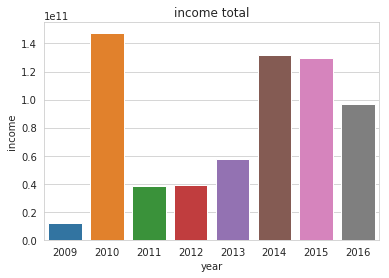

In [19]:
plt.figure()
plt.title('income total')
sns.barplot(yearly_assets_sum.index, yearly_assets_sum.income)
plt.show()

In [20]:
yearly_assets_median = declarations_df.groupby(['year']).median()
yearly_assets_median.head()

,person_id,office_id,income,savings,real_estate_amount,real_estate_squares
year,,,,,,
2009,5379.0,88.0,1857966.00,0.0,5.0,1177.70
2010,2848.5,99.5,1763236.50,0.0,4.0,821.54
2011,3933.0,560.0,1499000.00,0.0,4.0,782.40
2012,3945.0,657.0,1683191.00,0.0,4.0,817.60
2013,11215.5,1156.0,1633498.35,0.0,4.0,494.70


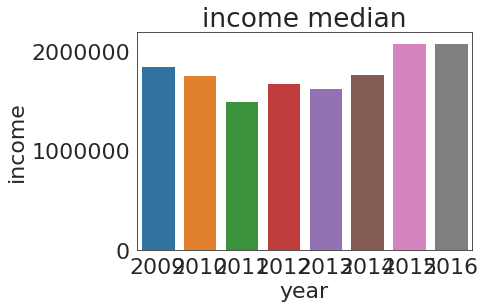

In [58]:
plt.figure()
plt.title('income median')
sns.barplot(yearly_assets_median.index, yearly_assets_median.income)
plt.show()   

In [59]:
office_people_counts = declarations_df.groupby(['office_id'])['person_id'].count().sort_values(ascending=False)
big_offices = office_people_counts[office_people_counts > office_people_counts.quantile(0.75)] # over 35 people in office 
big_offices.shape

(523,)

In [60]:
big_office_declarations = declarations_df[declarations_df.office_id.isin(big_offices.index)]
print(big_office_declarations.shape)
big_office_declarations.head()

(73634, 9)


,person_id,person_name,year,office_id,office_name,income,savings,real_estate_amount,real_estate_squares
4,8,Зюганов Геннадий Андреевич,2009,14,Государственная\nДума,2177821.52,0.0,3,448.7
5,8,Зюганов Геннадий Андреевич,2010,14,Государственная\nДума,2126487.00,3126451.0,1,167.4
6,8,Зюганов Геннадий Андреевич,2010,14,Государственная\nДума,2296288.43,0.0,3,448.7
8,8,Зюганов Геннадий Андреевич,2011,14,Государственная\nДума,2315222.88,0.0,3,448.7
9,8,Зюганов Геннадий Андреевич,2012,14,Государственная\nДума,2653015.42,0.0,3,448.7


In [61]:
# Total income per office
office_assets_sum = declarations_df.groupby(['office_name']).sum().sort_values(by='income', ascending=False)
office_assets_sum.head()

,person_id,year,office_id,income,savings,real_estate_amount,real_estate_squares
office_name,,,,,,,
Президент\nРоссийской\nФедерации,5878,26150,5837,1.153584e+11,5.553759e+09,86,7.920440e+04
Государственная\nДума,8375435,8121847,56504,1.081609e+11,2.427273e+10,37283,5.965931e+09
Совет\nФедерации,2790966,2017563,5010,2.965524e+10,0.000000e+00,9914,2.988004e+08
Правительство\nРФ,488940,613807,138165,1.290824e+10,0.000000e+00,3380,3.287185e+08
"По\nсодействию\nразработке,\nпроизводству\nи\nэкспорту\nвысокотехнологичной\nпромышленной\nпродукции\n""Ростехнологии""",7062782,449137,216310,1.114673e+10,0.000000e+00,1933,2.679097e+06


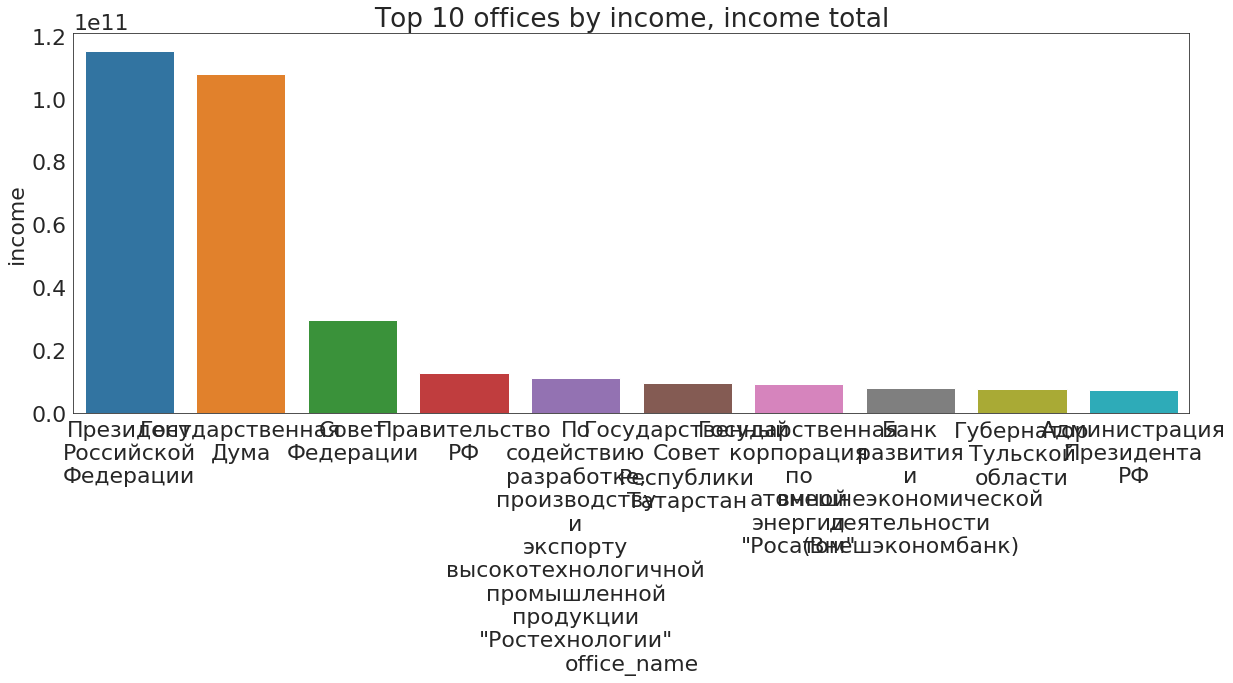

In [62]:
to_plot = office_assets_sum.head(10)

plt.figure(figsize=(20, 7))
plt.title('Top 10 offices by income, income total')
sns.barplot(to_plot.index, to_plot.income)
plt.show()

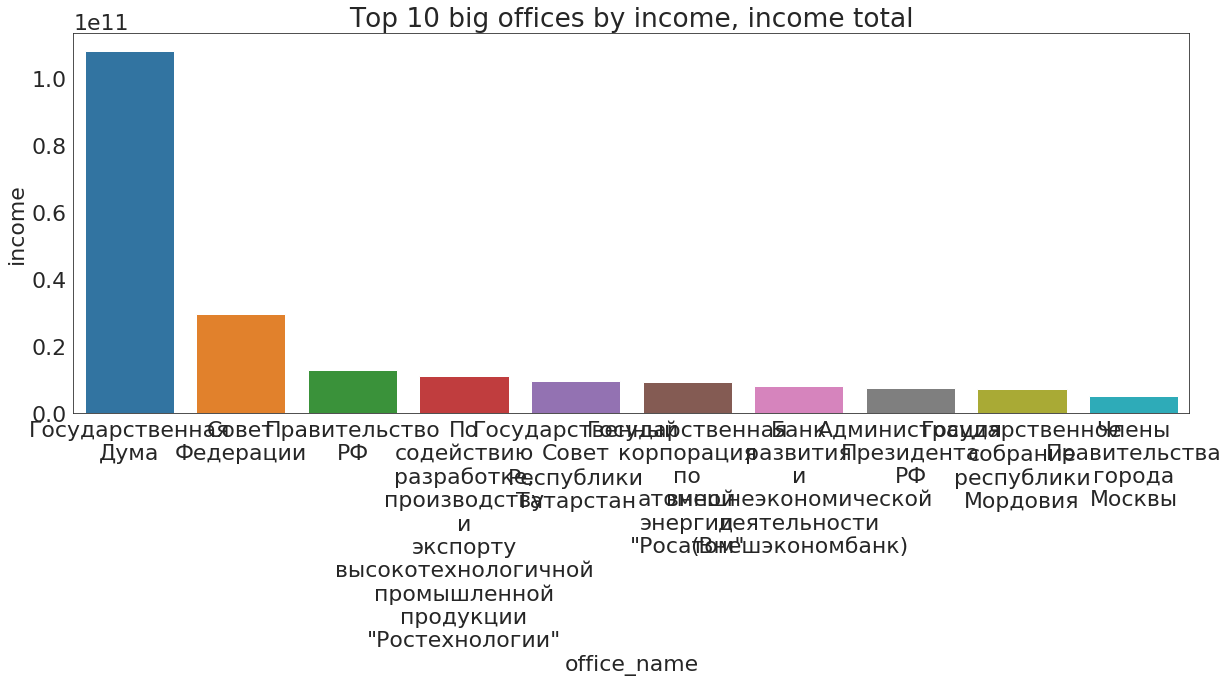

In [63]:
# Total income per office, only big offices
office_assets_sum = big_office_declarations.groupby(['office_name']).sum().sort_values(by='income', ascending=False)
to_plot = office_assets_sum.head(10)
plt.figure(figsize=(20, 7))
plt.title('Top 10 big offices by income, income total')
sns.barplot(to_plot.index, to_plot.income)
plt.show()

In [64]:
# Median income per office
office_assets_median = big_office_declarations.groupby(['office_name']).median().sort_values(by='income', ascending=False)
office_assets_median.head()

,person_id,year,office_id,income,savings,real_estate_amount,real_estate_squares
office_name,,,,,,,
Законодательное\nСобрание\nЯмало-Ненецкого\nавтономного\nокруга,15341.0,2015.0,954.0,18989454.68,0.0,7.0,2117.50
Центральный\nБанк\n,19726.0,2016.0,612.0,15771908.20,0.0,8.5,2590.95
Министерство\nфинансов\n,11670.0,2016.0,604.0,15764996.02,0.0,9.0,3584.80
"Государственная\nкорпорация\nпо\nатомной\nэнергии\n""Росатом""",38411.0,2014.0,969.0,15162543.02,0.0,8.0,2229.90
Банк\nразвития\nи\nвнешнеэкономической\nдеятельности\n(Внешэкономбанк),32297.5,2014.0,966.0,12522960.94,0.0,7.0,1622.65


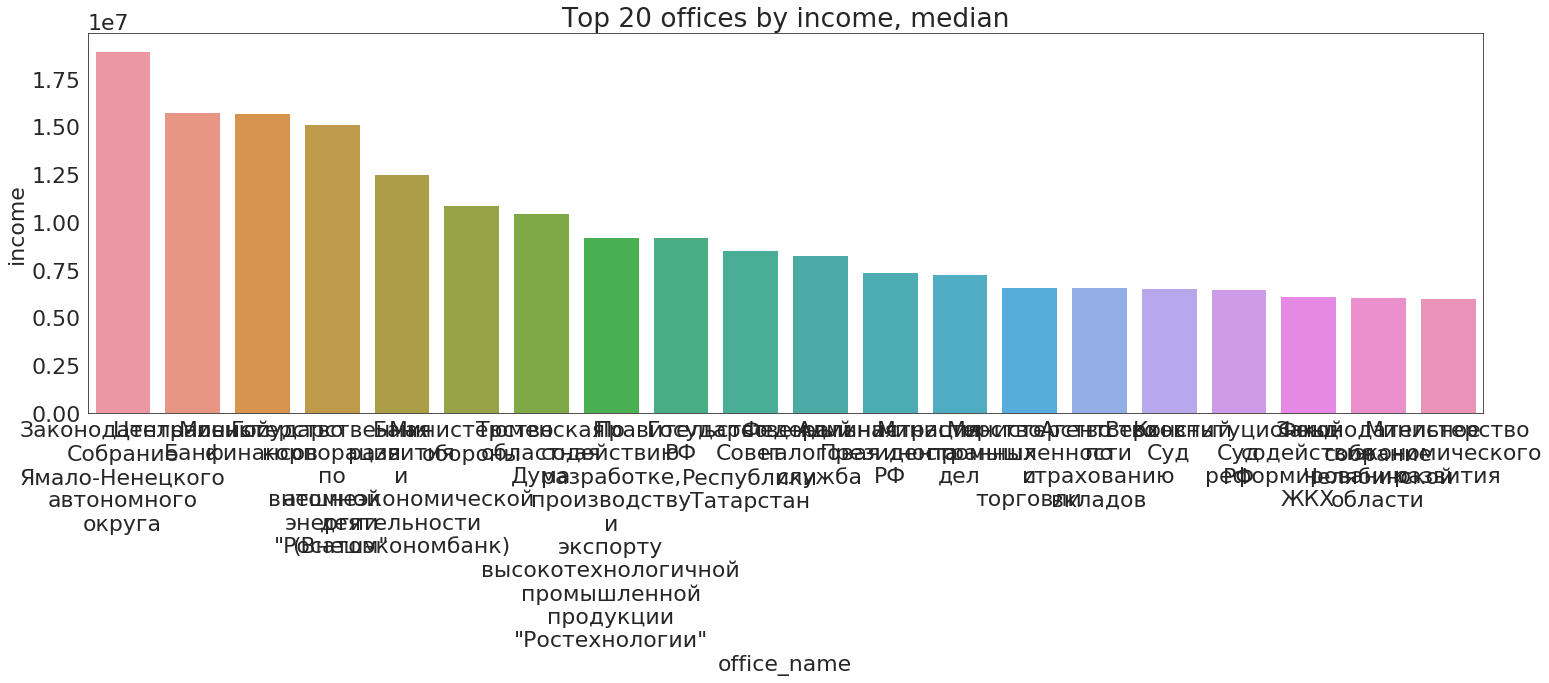

In [65]:
to_plot = office_assets_median.head(20)
plt.figure(figsize=(25, 7))
plt.title('Top 20 offices by income, median')
sns.barplot(to_plot.index, to_plot.income)
plt.show()

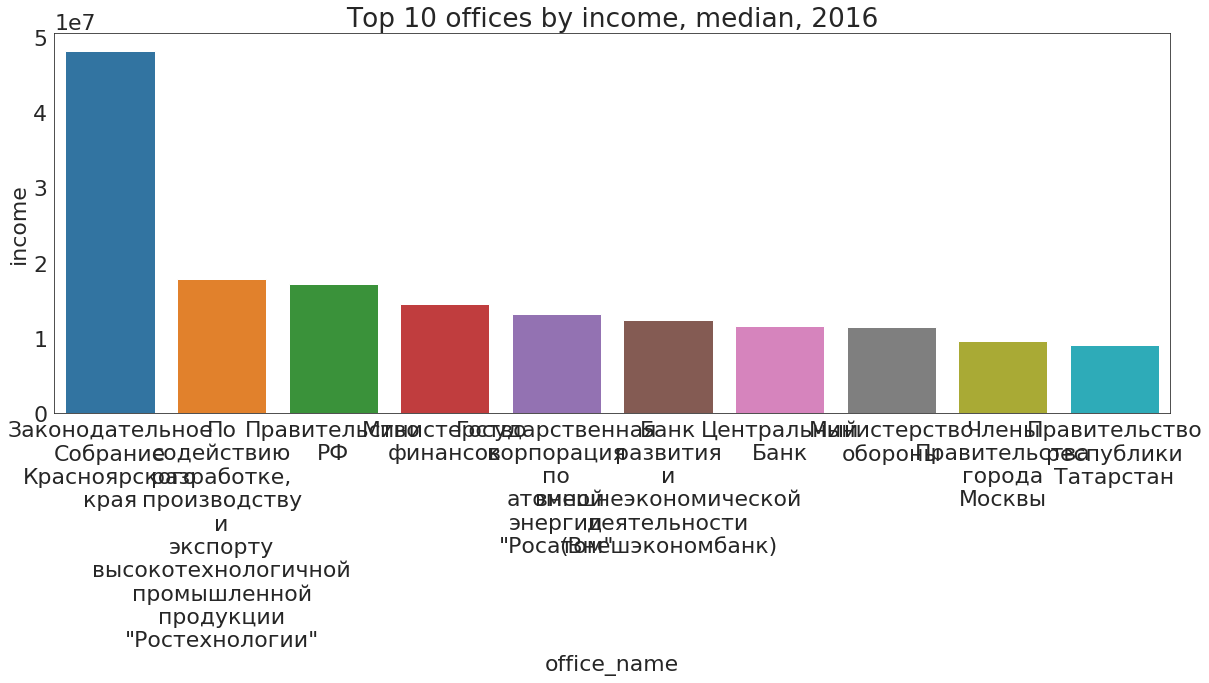

In [66]:
# Median income per office in 2016
office_assets_median = big_office_declarations[big_office_declarations.year == 2016].groupby(['office_name']).median().sort_values(by='income', ascending=False)
office_assets_median.head()
to_plot = office_assets_median.head(10)
plt.figure(figsize=(20, 7))
plt.title('Top 10 offices by income, median, 2016')
sns.barplot(to_plot.index, to_plot.income)
plt.show()

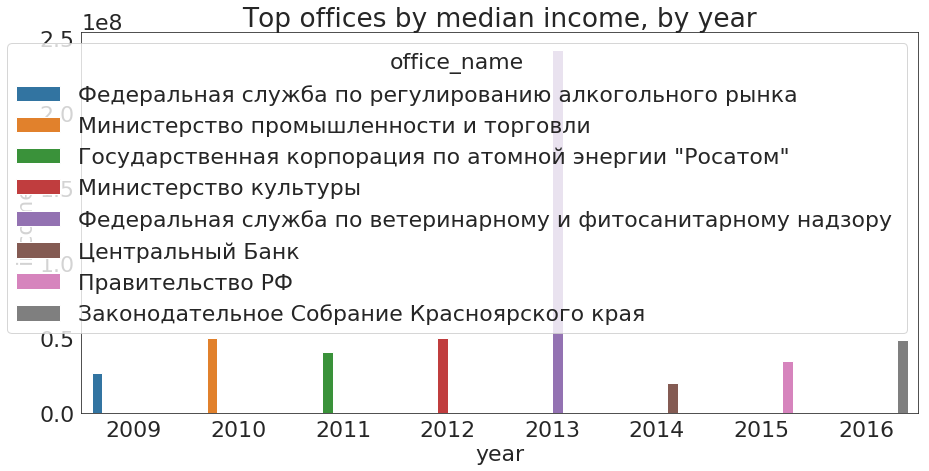

In [67]:
# Top offices by median income, by year
tdf= big_office_declarations.groupby(['year', 'office_name'])['income'].median().reset_index()
tdf2 = tdf.groupby('year')['income'].max().reset_index()
tdf_final = tdf.merge(tdf2, on=['year', 'income'], how='inner')
tdf_final.office_name = tdf_final.office_name.apply(lambda x: x.replace('\n', ' '))
plt.figure(figsize=(15,7))
plt.title('Top offices by median income, by year')
sns.barplot(x='year', y='income', hue='office_name', data=tdf_final)
plt.show()

### Income distributions
* Income percentile distributions

In [68]:
percentiles = [0, 0.75, 0.95, 0.99, 0.9999, 1]
labels = ['p'+str(percentiles[i-1]) +' - ' +str(percentiles[i]) for i in range(1, len(percentiles))]
qcut, bins = pd.qcut(income_sum, percentiles, labels=labels, retbins=True)

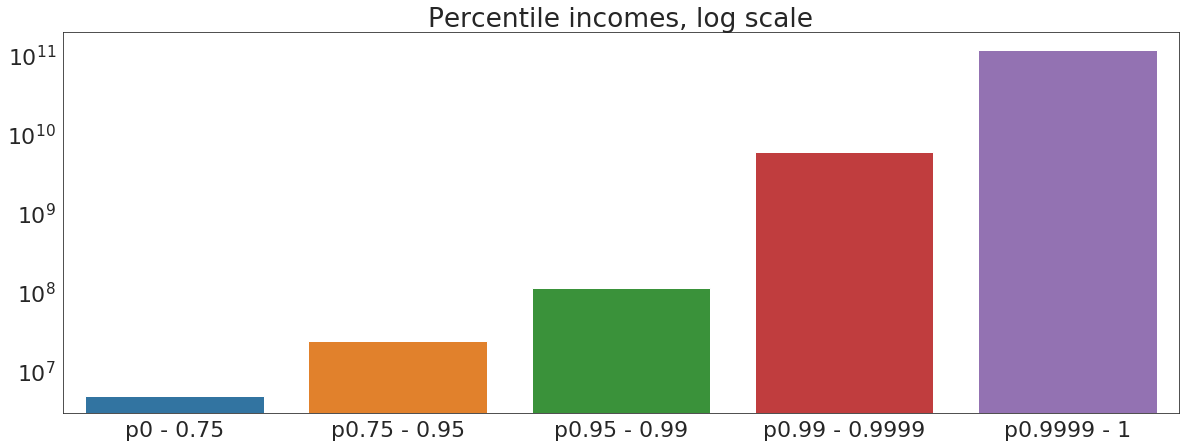

In [69]:
plt.figure(figsize=(20, 7))
plt.title('Percentile incomes, log scale')
sns.barplot(labels, bins[1:])
plt.yscale('log')
plt.show()

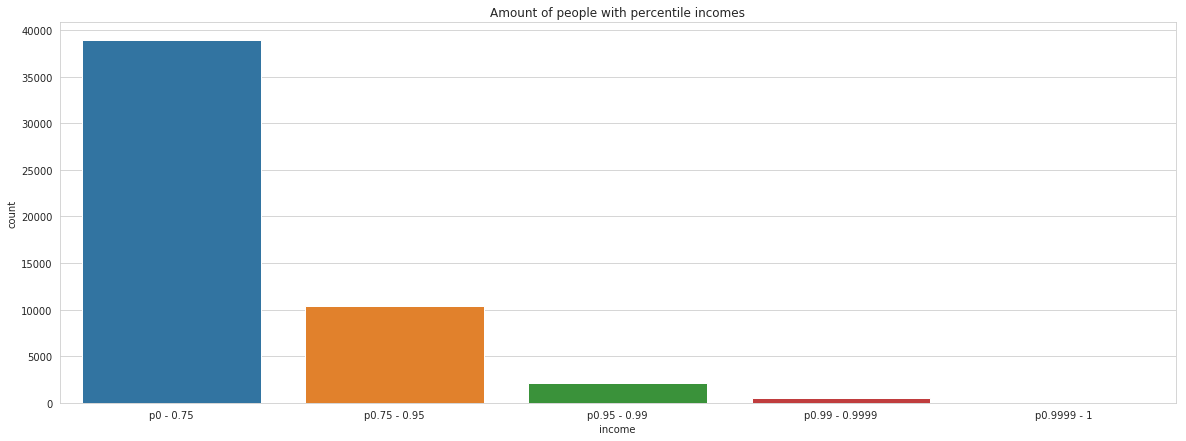

In [31]:
plt.figure(figsize=(20, 7))
plt.title('Amount of people with percentile incomes')
sns.countplot(qcut)
plt.show()

Total income


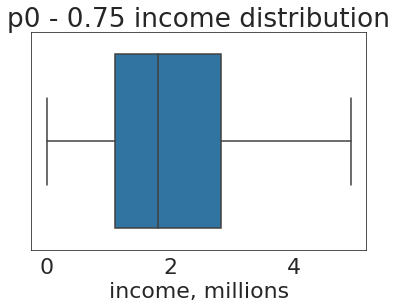

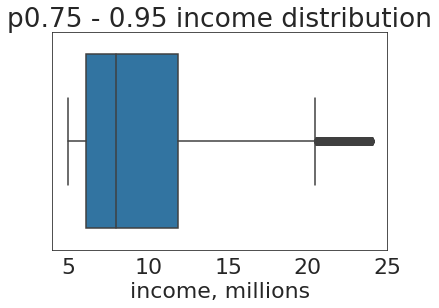

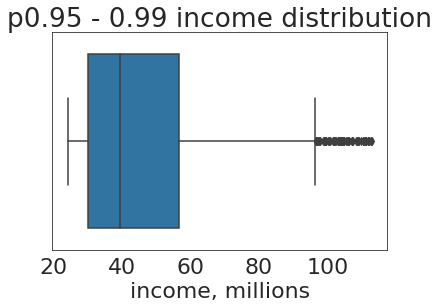

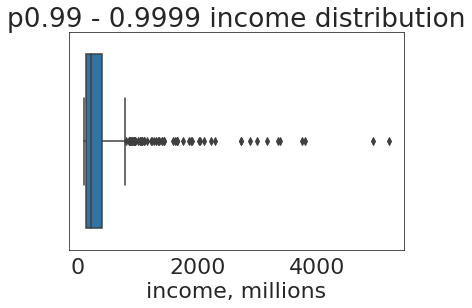

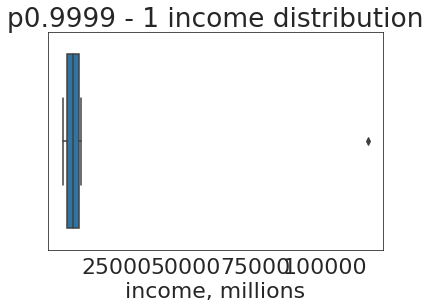

In [70]:
print('Total income')
for percentile in labels:
    percentile_persons = qcut[qcut == percentile].index
    
    percentile_income = income_sum.loc[percentile_persons]
    
    plt.figure()
    plt.title(percentile +' income distribution')
    millions_xlabel = False
    if percentile_income.max() >= 1e6:
        percentile_income = percentile_income / 1e6
        millions_xlabel = True
    sns.boxplot(percentile_income)
    if millions_xlabel:
        plt.xlabel('income, millions')
    plt.show()

Median income


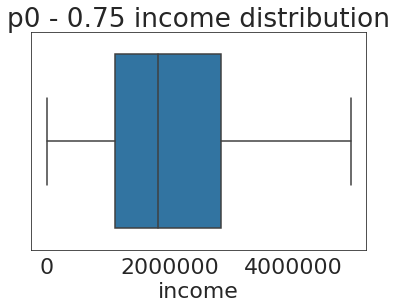

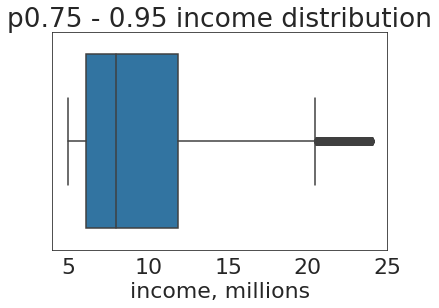

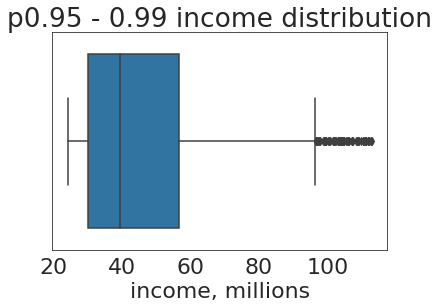

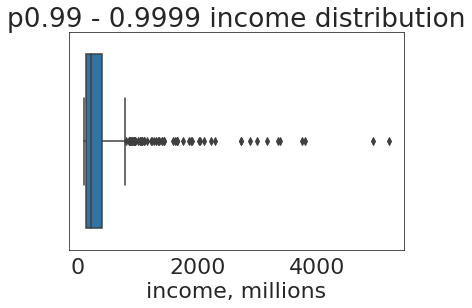

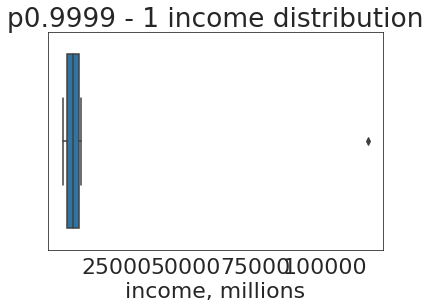

In [71]:
print('Median income')
for percentile in labels:
    percentile_persons = qcut[qcut == percentile].index
    
    percentile_income = income_sum.loc[percentile_persons]
    
    plt.figure()
    plt.title(percentile +' income distribution')
    millions_xlabel = False
    if percentile_income.min() >= 1e6:
        percentile_income = percentile_income / 1e6
        millions_xlabel = True
    sns.boxplot(percentile_income)
    if millions_xlabel:
        plt.xlabel('income, millions')
    plt.show()

In [72]:
final_df = pd.DataFrame(index=range(1, 11))
for year in declarations_df.year.unique():
    tdf = declarations_df[declarations_df.year == year].groupby(['person_name'])['income'].sum().sort_values(ascending=False)
    top_10 = list(tdf.head(10).index)
    final_df[year] = top_10

print('Top 10 people by income, each year')
final_df

Top 10 people by income, each year


,2009,2010,2011,2012,2013,2014,2015,2016
1,Груздев Владимир Сергеевич,Прохоров Михаил Дмитриевич,Груздев Владимир Сергеевич,Груздев Владимир Сергеевич,Аникеев Григорий Викторович,Сиушов Сергей Иванович,Ахоян Галуст Цолакович,Пономарев Валерий Андреевич
2,Аникеев Григорий Викторович,Зубицкий Борис Давыдович,Аникеев Григорий Викторович,Борцов Николай Иванович,Малкин Ефим Наумович,Чемезов Сергей Викторович,Сабиров Рустам Наилович,Минниханов Рустам Нургалиевич
3,Борцов Николай Иванович,Груздев Владимир Сергеевич,Петров Сергей Анатольевич,Аникеев Григорий Викторович,Слипенчук Михаил Викторович,Груздев Владимир Сергеевич,Ильтяков Дмитрий Владимирович,Чемезов Сергей Викторович
4,Гребенкин Олег Анатольевич,Борцов Николай Иванович,Гурьев Андрей Григорьевич,Ананьев Дмитрий Николаевич,Груздев Владимир Сергеевич,Аникеев Григорий Викторович,Басанский Александр Александрович,Богомаз Александр Васильевич
5,Комаров Фоат Фагимович,Аникеев Григорий Викторович,Борцов Николай Иванович,Каланда Владимир Александрович,Дарькин Сергей Михайлович,Соколов Михаил Юрьевич,Глебова Любовь Николаевна,Рассудов Александр Николаевич
6,Шувалов Игорь Иванович,Резник Владислав Матусович,Малкин Виталий Борисович,Гурьев Андрей Григорьевич,Чемезов Сергей Викторович,Зотов Владимир Федорович,Дерев Эдуард Вячеславович,Палкин Андрей Васильевич
7,Волков Юрий Николаевич,Дарькин Сергей Михайлович,Хлопонин Александр Геннадиевич,Петров Сергей Анатольевич,Симановский Леонид Яковлевич,Слипенчук Михаил Викторович,Пономарев Валерий Андреевич,Некрасов Александр Николаевич
8,Зубицкий Борис Давыдович,Муравленко Сергей Викторович,Милявский Александр Борисович,Саблин Дмитрий Вадимович,Борцов Николай Иванович,Некрасов Александр Николаевич,Евтушок Игорь Петрович,Кузнецов Лев Владимирович
9,Володин Вячеслав Викторович,Медведев Евгений Николаевич,Слипенчук Михаил Викторович,Пичугов Виктор Александрович,Шувалов Игорь Иванович,Вайнштейн Сергей Евгеньевич,Шутов Андрей Васильевич,Борцов Николай Иванович
10,Зеленин Дмитрий Вадимович,Гребенкин Олег Анатольевич,Мошкович Вадим Николаевич,Чемезов Сергей Викторович,Богомаз Александр Васильевич,Басанский Александр Александрович,Симановский Леонид Яковлевич,Седых Марина Владимировна


In [34]:
years_worked = declarations_df.groupby(['person_id'])['year'].nunique()
years_worked.name = 'years worked'
years_worked.head()

person_id
8     8
9     8
10    7
11    4
12    8
Name: years worked, dtype: int64

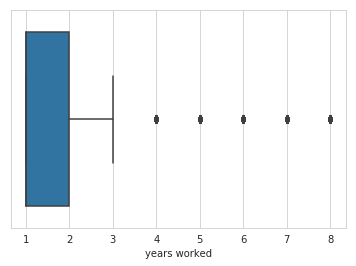

In [35]:
plt.figure()
sns.boxplot(years_worked)
plt.show()

/home/boris/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


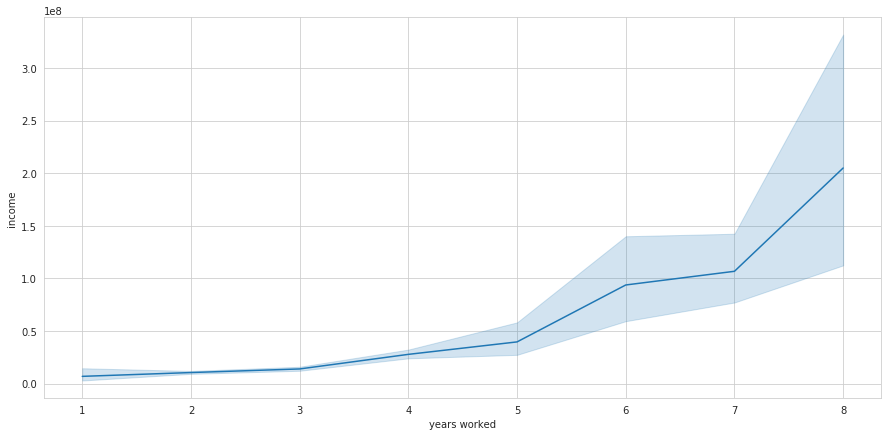

In [36]:
income = declarations_df.groupby(['person_id'])['income'].sum()
income = income.loc[years_worked.index]
plt.figure(figsize=(15, 7))
sns.lineplot(years_worked, income)
plt.show()

/home/boris/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


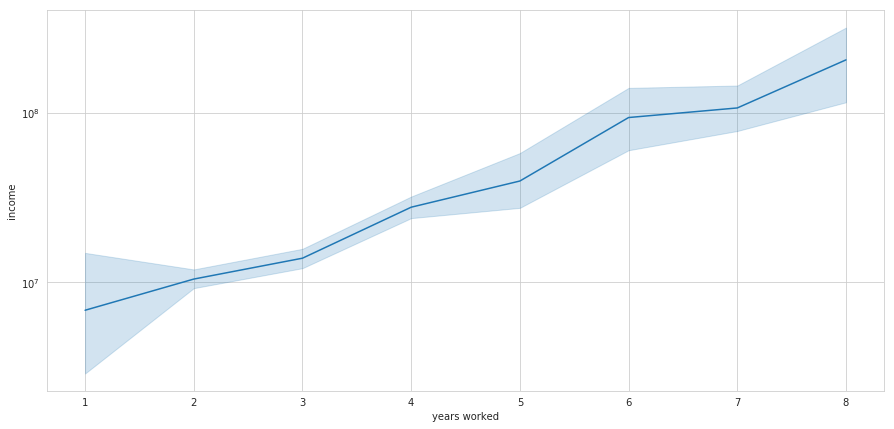

In [37]:
# We can observe a log dependency
plt.figure(figsize=(15, 7))
sns.lineplot(years_worked, income)
plt.yscale('log')
plt.show()

/home/boris/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


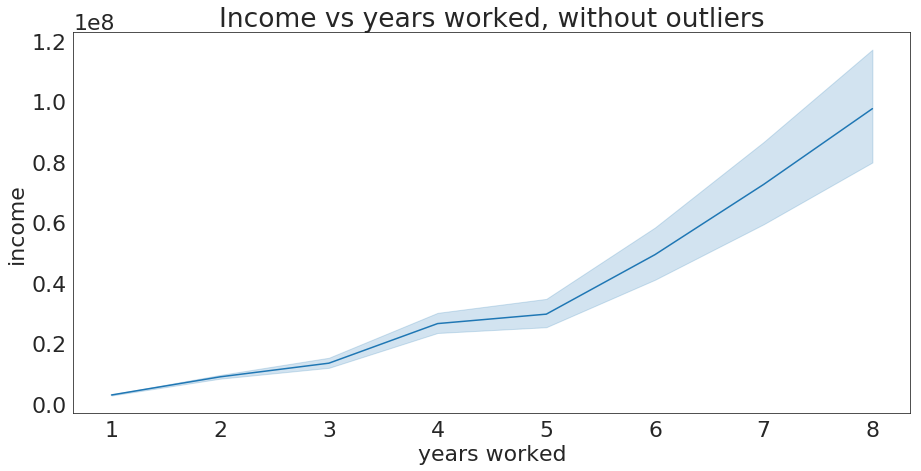

In [73]:
income_filtered = income[(income < income.mean()+2*income.std()) & (income > income.mean()-2*income.std())]
years_worked_filtered = years_worked.loc[income_filtered.index]
plt.figure(figsize=(15, 7))
plt.title("Income vs years worked, without outliers")
sns.lineplot(years_worked_filtered, income_filtered)
plt.show()

In [ ]:

def clean_up_data(df):
    df = df[(df.year >= 2009) & (df.year <= 2016)]
    income = df.income
    df = df[(income < income.mean()+3*income.std()) & (income > income.mean()-3*income.std())]
    return df